# Installation

In [1]:
!pip install src/

Defaulting to user installation because normal site-packages is not writeable
Processing ./src
  Preparing metadata (setup.py) ... done
  Created wheel for multipers: filename=multipers-0.0.0-cp311-cp311-linux_x86_64.whl size=2575431 sha256=68ad248f68012b438a7a1e3390f76ffca8071f6194e75e167a2d185c4ad21f9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-cea0bu1p/wheels/e0/9a/09/e13d3e2e1de361192fcb303115abbf771f8e4c26fb3f7e3a68
Successfully built multipers
  Attempting uninstall: multipers
    Found existing installation: multipers 0.0.0
    Uninstalling multipers-0.0.0:
      Successfully uninstalled multipers-0.0.0


# Setup


In [1]:
import multipers
from mma import noisy_annulus
import gudhi as gd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import numpy as np

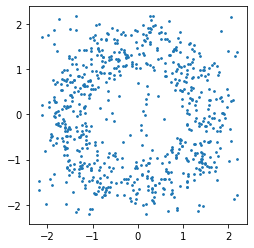

In [2]:
npts = 500
noutliers = (int)(npts * 0.4)
np.random.seed(100)
X = noisy_annulus(n1=npts, n2=noutliers)
ax = plt.gca();ax.set_aspect('equal')
plt.scatter(X[:,0], X[:,1],s=3)

## Rips + codensity

In [3]:
simplextree = gd.RipsComplex(points = X).create_simplex_tree()
simplextree = multipers.from_gudhi(simplextree, num_parameters = 2)
density = KernelDensity(bandwidth=0.25).fit(X).score_samples(X)
simplextree.fill_lowerstar(-density, parameter=1)
simplextree.collapse_edges(num=100, progress=1, max_dimension=2)

Removing edges:  11%|█         | 11/100 [00:09<01:18,  1.13it/s]


## Turns the filtrations of the simplextree to coordinate in a grid

In [4]:
grid_shape = [50,50]
st = multipers.SimplexTree(simplextree) # Copy (for later) as grid_squeeze change filtration values
filtration_grid = st.grid_squeeze(resolution=grid_shape, coordinate_values=True, grid_strategy="regular") # regular can be replaced by quantiles

In [5]:
# There are way less filtration values -> edge collapse
st.collapse_edges(full=True, progress=1, max_dimension=2)
st.num_simplices()

/tmp/ipykernel_140247/1945668692.py:2: UserWarning: This method ignores simplices of dimension > 1 !
  st.collapse_edges(full=True, progress=1, max_dimension=2)
Removing edges:  23%|██▎       | 23/100 [00:05<00:19,  4.03it/s]


8685

In [6]:
## The rank inv assumes that st is a coordinate simplextree
rank_tensor = multipers.rank_inv(simplextree=st, degree=1, grid_shape=grid_shape) ## Only works for 2-parameter simplextrees

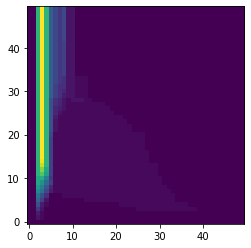

In [7]:
hilbert = multipers.hilbert2d(simplextree=st, degree=1, grid_shape=grid_shape) ## Only works for 2-parameter simplextrees
plt.imshow(hilbert.T, origin="lower")

## Rectangle decomposition, signed measure

In [8]:
from signed_betti import signed_betti, rank_decomposition_by_rectangles, tensor_to_rectangle, betti_matrix2signed_measure

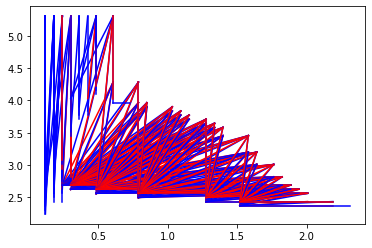

In [9]:
rectangle_decompo = rank_decomposition_by_rectangles(rank_tensor)
rectangle_decompo = tensor_to_rectangle(rectangle_decompo, plot=True, grid_conversion=filtration_grid)

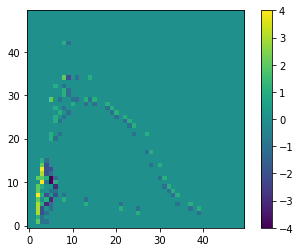

In [10]:
betti = signed_betti(hilbert_function=hilbert)
signed_measure = betti_matrix2signed_measure(betti)
plt.imshow(betti.T, origin="lower")
plt.colorbar()

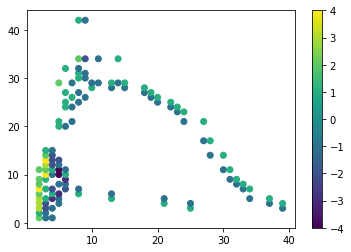

In [11]:
plt.figure()
plt.scatter(signed_measure[:,0], signed_measure[:,1], c=signed_measure[:,2])
plt.colorbar()

In [12]:
def rectangles2matrix(rectangles, grid_shape)->np.ndarray:
    img = np.zeros(shape=grid_shape)
    for b, d, r in rectangles:
        img[*b] += r
        img[*d] -= r
    return img

def rectangle2GaussConv(rectangles, filtration_grid, kernel = "gaussian", bandwidth=0.1):
    from itertools import product
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    pts_plus = [b for b,d,r in rectangles for _ in range(int(r)) if r>0] + [d for b,d,r in rectangles for _ in range(int(-r)) if r<0]
    pts_minus = [b for b,d,r in rectangles for _ in range(int(-r)) if r<0] + [d for b,d,r in rectangles for _ in range(int(r)) if r>0]
    grid_iterator = np.asarray(list(product(*filtration_grid)))
    grid_shape = [len(f) for f in filtration_grid]
    img_pos = kde.fit(pts_plus).score_samples(grid_iterator).reshape(grid_shape)
    img_neg = kde.fit(pts_minus).score_samples(grid_iterator).reshape(grid_shape)
    return img_pos - img_neg
def hilbert2GaussConv(betti_iterable, filtration_grid, kernel="gaussian", bandwidth=0.1):
    from itertools import product
    from sklearn.neighbors import KernelDensity
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth)
    grid_iterator = np.asarray(list(product(*filtration_grid)))
    grid_shape = [len(f) for f in filtration_grid]
    pos_pts = np.asarray([x[:-1] for x in betti_iterable for _ in range(int(x[-1])) if x[-1] > 0])
    neg_pts = np.asarray([x[:-1] for x in betti_iterable for _ in range(int(-x[-1])) if x[-1] < 0])
    img_pos = kde.fit(pos_pts).score_samples(grid_iterator).reshape(grid_shape)
    img_neg = kde.fit(neg_pts).score_samples(grid_iterator).reshape(grid_shape)
    return img_pos - img_neg